In [1]:
!pip -q install opencv-python scikit-image scikit-learn joblib tensorflow

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
import joblib

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test  = y_test.flatten()

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [4]:
def gaussian_denoise(img, ksize=3):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

def median_denoise(img, ksize=3):
    return cv2.medianBlur(img, ksize)

def clahe_on_l_channel(img, clipLimit=2.0, tileGridSize=(8,8)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

def contrast_stretch(img):
    img_f = img.astype(np.float32) / 255.0
    p2, p98 = np.percentile(img_f, (2, 98))
    out = (img_f - p2) / (p98 - p2 + 1e-8)
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

def preprocess(img,
               use_gaussian=True,
               use_median=False,
               use_clahe=True,
               use_contrast=True):
    out = img.copy()
    if use_gaussian:
        out = gaussian_denoise(out, 3)
    if use_median:
        out = median_denoise(out, 3)
    if use_clahe:
        out = clahe_on_l_channel(out)
    if use_contrast:
        out = contrast_stretch(out)
    return out

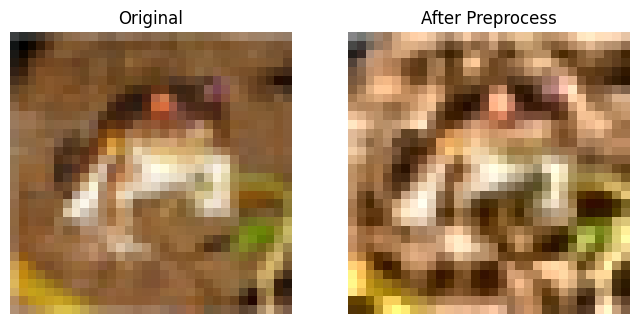

Label: frog


In [5]:
idx = 0
img = x_train[idx]

img_p = preprocess(img, use_gaussian=True, use_median=False, use_clahe=True, use_contrast=True)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img);   plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img_p); plt.title("After Preprocess"); plt.axis("off")
plt.show()

print("Label:", class_names[y_train[idx]])

In [6]:
N_TRAIN = 15000
N_TEST  = 3000

xtr = x_train[:N_TRAIN]
ytr = y_train[:N_TRAIN]
xte = x_test[:N_TEST]
yte = y_test[:N_TEST]

print(xtr.shape, xte.shape)

(15000, 32, 32, 3) (3000, 32, 32, 3)


In [7]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224,224,3)
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
def preprocess_batch(batch):
    out = np.empty_like(batch)
    for i in range(len(batch)):
        out[i] = preprocess(batch[i])
    return out

def extract_deep_features(images, batch_size=64):
    feats_list = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = preprocess_batch(batch)

        batch = tf.image.resize(batch, (224,224)).numpy().astype(np.float32)
        batch = preprocess_input(batch)

        feats = base_model.predict(batch, verbose=0)
        feats_list.append(feats)

    return np.vstack(feats_list)

Xtr_feat = extract_deep_features(xtr, batch_size=64)
Xte_feat = extract_deep_features(xte, batch_size=64)

print("Feature shape train:", Xtr_feat.shape)
print("Feature shape test :", Xte_feat.shape)

Feature shape train: (15000, 1280)
Feature shape test : (3000, 1280)


In [9]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1.0))
])

clf.fit(Xtr_feat, ytr)
y_pred = clf.predict(Xte_feat)

acc = accuracy_score(yte, y_pred)
p, r, f1, _ = precision_recall_fscore_support(yte, y_pred, average="macro", zero_division=0)

print("Accuracy:", acc)
print("Precision(macro):", p)
print("Recall(macro):", r)
print("F1(macro):", f1)

print("\nClassification report:")
print(classification_report(yte, y_pred, target_names=class_names, zero_division=0))

Accuracy: 0.5673333333333334
Precision(macro): 0.5645517496339921
Recall(macro): 0.5671159229122694
F1(macro): 0.5649231601216294

Classification report:
              precision    recall  f1-score   support

    airplane       0.59      0.55      0.57       299
  automobile       0.68      0.68      0.68       287
        bird       0.52      0.44      0.48       318
         cat       0.44      0.42      0.43       295
        deer       0.47      0.49      0.48       299
         dog       0.51      0.47      0.49       290
        frog       0.62      0.70      0.66       307
       horse       0.55      0.59      0.57       286
        ship       0.66      0.68      0.67       316
       truck       0.60      0.65      0.62       303

    accuracy                           0.57      3000
   macro avg       0.56      0.57      0.56      3000
weighted avg       0.56      0.57      0.57      3000



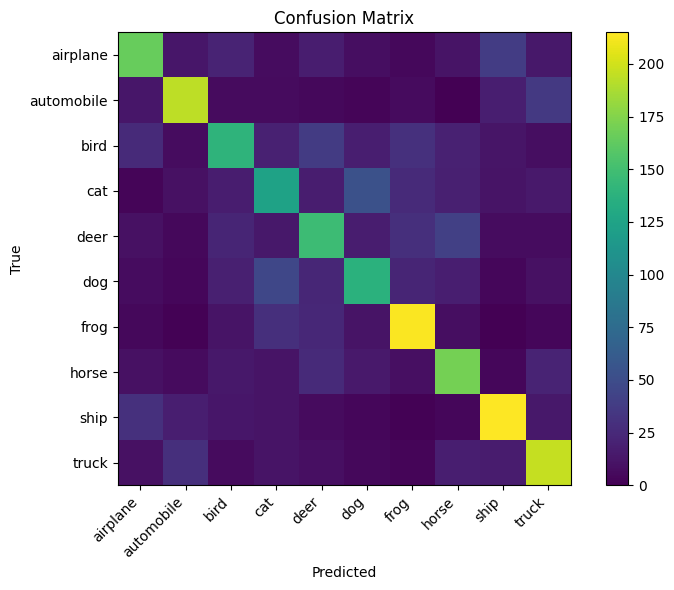

In [10]:
cm = confusion_matrix(yte, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
param_grid = {"svm__C": [0.1, 1, 3]}
gs = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)
gs.fit(Xtr_feat, ytr)

print("Best params:", gs.best_params_)
best_model = gs.best_estimator_

y_pred2 = best_model.predict(Xte_feat)
acc2 = accuracy_score(yte, y_pred2)
p2, r2, f12, _ = precision_recall_fscore_support(yte, y_pred2, average="macro", zero_division=0)

print("After tuning - Accuracy:", acc2)
print("After tuning - Precision(macro):", p2)
print("After tuning - Recall(macro):", r2)
print("After tuning - F1(macro):", f12)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'svm__C': 0.1}
After tuning - Accuracy: 0.576
After tuning - Precision(macro): 0.5734836640198947
After tuning - Recall(macro): 0.575738908325784
After tuning - F1(macro): 0.5736699845961242


In [13]:
joblib.dump(best_model if "best_model" in globals() else clf, "svm_cifar10_mobilenet.joblib")

pre_cfg = dict(use_gaussian=True, use_median=False, use_clahe=True, use_contrast=True)
joblib.dump(pre_cfg, "preprocess_config.joblib")

print("Saved: svm_cifar10_mobilenet.joblib & preprocess_config.joblib")

Saved: svm_cifar10_mobilenet.joblib & preprocess_config.joblib
